# 클래스 선언

In [114]:
# backup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import deque
font_path = "C:\Windows\Fonts\LG_Smart_UI-Light.ttf"

from matplotlib import font_manager, rc

font = font_manager.FontProperties(fname = font_path).get_name()
rc('font', family = font)

# ## input에 대한 실린더 고장 클래스
# ## input_data(csv) 가 모여있는 디렉토리 입력.


## 실린더 정보 저장용
class CYLINDER():
    def __init__(self, is_abnormal = None, value_data = None, max_limit = None, min_limit = None, count = None):
        self.stat = is_abnormal     # 이상유무 1 = 이상, 0 = 정상 , [1, 0, 1, 0, 1] --> 0, 2, 4 번째 실린더 이상
        self.value = value_data     # 각 실린더마다 데이터
        self.max_limit = max_limit  # 각 실린더마다 상한선 변동값
        self.min_limit = min_limit  # 각 실린더마다 하한성 변동값
        self.count = count          # 넘어간 횟수

    # 요약정보 가져오기 위해
    def get(self, index):
        return [self.stat[index], self.value, self.max_limit, self.min_limit, self.count]

class CYL_DETECTOR():


    ## 초기세팅, 데이터 입력 부분
    def __init__(self, file_path):

        self.csv_path = file_path



    ## 동작시키는 함수 ##
    def run(self):

        print(f' 실린더 파일 읽는 중 ... ' , end='\r', flush=True)
        self.df = self.data_preprocess()

        print(f' 실린더 파일 읽는 중 ... 완료  ', end = "\n ", flush=True)
        self.cylinder_info_std = self.cylinder_analysis_std(self.df)
        self.cylinder_info_crest = self.cylinder_analysis_crest(self.df)
        self.result = []

        ####

        # std와 crest 겹치는 인덱스 찾는 부분

        ####


    # 전처리 필요하면 여기 ~~~~~~~~~
    def data_preprocess(self):
        original = pd.read_csv(self.csv_path, encoding='CP949') # 시간 포함
        copy_df = pd.DataFrame(np.copy(original),columns = original.columns)    # 시간 필터링
        copy_df = copy_df.iloc[:, 1:]
        self.df_columns = copy_df.columns



        del(original)
        return copy_df

    #############  알고리즘 - 1


    ############################################# 한계선 ############################################
    def determine_limit(self, data, sigma, weight):
        std, mean = np.std(data), np.mean(data)

        if std * sigma >= 0.1:
            upper_line = (mean + std * sigma) * (1 + weight)
            lower_line = (mean - std * sigma) * (1 - weight)
        else:
            upper_line = (mean + 0.1) * (1 + weight)
            lower_line = (mean - 0.1) * (1 - weight)

        if lower_line < 0 : lower_line = 0

        return upper_line, lower_line, std, mean
    #################################################################################################


    def cylinder_analysis_std(self, cyl_dataframe):

        ######## 리턴용 변수 생성 ########
        type, value, max, min, cnt = [], [], [], [], []
        self.sigma, self.weight, self.limit = 3, 0.01, 100
        ##############################

        # 1. Input 데이터를 입력받는다.
        cyl_size = len(cyl_dataframe.columns)
        data_size = len(cyl_dataframe)


        ## 탐색 (전체 실린더)
        for cyl_i in range(cyl_size):
            ###### 전체 변수 & 초기화 ####
            is_abnormal, count, repeat_counter = 0, 0, 0
            upper_limit, lower_limit = [], []
            upper_line, lower_line = 0, 0
            std, mean = 0, 0
            is_collected = False


            data_box = deque()
            cylinder_data = cyl_dataframe.iloc[:, cyl_i]
            ############################

            ## 탐색 (개별 실린더)
            for idx, data in enumerate(cylinder_data):

                # 데이터 수집안됐으면 추가하고 다음으로
                if not is_collected:
                    if len(data_box) < int(data_size/ 10):
                        data_box.append(data)
                        upper_limit.append(None)
                        lower_limit.append(None)

                        continue

                    # 수집했으면 std, mean 라인 스타트
                    if len(data_box) == int(data_size/ 10):

                        upper_line, lower_line, std, mean = self.determine_limit(data_box, self.sigma, self.weight)
                        # std = (np.std(data_box))
                        # mean = (np.mean(data_box))
                        # 한계선 업데이트
                        # upper_line = (mean + std * self.sigma) * (1 + self.weight)
                        # lower_line = (mean - std * self.sigma) * (1 - self.weight)

                        is_collected = True




                ####################### 이어서 할거 if  다음 어떻게 넘어갈지 막힘 아마도 std, mean 구해서 상하한선 구하는것부터 시작할것~~

                # data_box.append(data)
                # data_box.popleft()


                # if data == cylinder_data.iloc[idx-1]:
                #     repeat_counter += 1
                # else :
                #     repeat_counter = 0
                #
                # if repeat_counter > 1000:
                #     std = float(np.std(cylinder_data[idx - 1000: idx]))
                #     mean = float(np.mean(cylinder_data[idx - 1000: idx]))
                #     upper_line = (mean + std * sigma) * (1 + weight)
                #     lower_line = (mean - std * sigma) * (1 - weight)
                #     repeat_counter = 0


                ## std, mean 계산하기까지 데이터 모음
                if idx % int(data_size/10) == 0:

                    std = float(np.std(cylinder_data[idx - int(data_size/10): idx]))
                    mean = float(np.mean(cylinder_data[idx - int(data_size/10): idx]))

                    # weight *= 0.9
                    if std > mean * 0.01:
                        continue

                    # 한계선 업데이트
                    if std * self.sigma >= 0.1:
                        upper_line = (mean + std * self.sigma) * (1 + self.weight)
                        lower_line = (mean - std * self.sigma) * (1 - self.weight)
                    else:
                        upper_line = (mean + 0.1) * (1 + self.weight)
                        lower_line = (mean - 0.1) * (1 - self.weight)



                if data != 0 and (data > upper_line or data < lower_line):
                    count += 1

                    # test
                    # 한계선 업데이트
                    std = float(np.std(cylinder_data[idx - int(cyl_size/10): idx]))
                    mean = float(np.mean(cylinder_data[idx - int(cyl_size/10): idx]))

                    if std * self.sigma >= 0.1:
                        upper_line = (mean + std * self.sigma) * (1 + weight)
                        lower_line = (mean - std * self.sigma) * (1 - weight)
                    else:
                        upper_line = (mean + 0.1) * (1 + weight)
                        lower_line = (mean - 0.1) * (1 - weight)

                    if lower_line < 0 : lower_line = 0


                upper_limit.append(upper_line)
                lower_limit.append(lower_line)


            if count > 200:
                is_abnormal = 1


            # print(f' 실린더 분석 중 : {cyl_i + 1}/{cyl_size} 완료',end ="\r", flush =True)
            print(f' 실린더 분석 중 : {int(( (cyl_i+1) /cyl_size)*100)}% ( {cyl_i +1} / {cyl_size} )' , end='\r', flush=True)

            if is_abnormal:
                type.append(is_abnormal)
                value.append(cylinder_data)
                max.append(upper_limit)
                min.append(lower_limit)
                cnt.append(count)

            else:
                type.append(is_abnormal)
                value.append(cylinder_data)
                max.append(upper_limit)
                min.append(lower_limit)
                cnt.append(count)

        # cylinder 정보 저장
        cylinder = CYLINDER(is_abnormal = type, value_data = value, max_limit = max, min_limit = min, count = count)
        print(f' 실린더 분석 완료 : {int(( (cyl_i+1) /cyl_size)*100)}% ( {cyl_i +1} / {cyl_size} )' , end='\r', flush=True)

        # 반환

        return cylinder

    ##############  알고리즘 - 2

    def cylinder_analysis_crest(self, cyl_dataframe):
        pass



    # Test 용.
    def print(self):
        pass





## cylinder 끼리 비교 코드

1
3
5


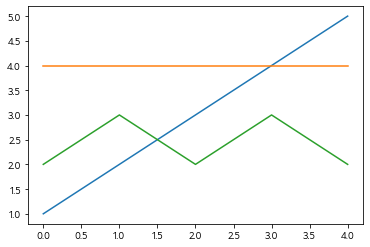

In [73]:
a = [1,0,1,0,1]
b = [1,1,1,1,1]
cylinder = CYLINDER(is_abnormal=a, value_data=[1,2,3,4,5], max_limit=[4,4,4,4,4], min_limit = [2,3,2,3,2], count= 2)
cylinder2 = CYLINDER(is_abnormal=b)

list = cylinder.stat
list2 = cylinder2.stat
for i, d in enumerate(cylinder.stat):
    if d in cylinder2.stat:
        print(i+1)

type, value, max, min, count = cylinder.get(1)

plt.plot(value)
plt.plot(max)
plt.plot(min)


# 최종 클래스 동작

In [108]:
os.getcwd()



detector = CYL_DETECTOR('data/PKG4/2109/20210913.csv')
# detector.data_preprocess()
detector.run()

# detector.original.columns

 실린더 파일 읽는 중 ... 완료  


### 테스트용 코드

In [113]:
# detector.cylinder_info_std.value[0]

plt.figure(figsize=(50,30))
b=0
c=0
for i in range(0,331):

    if   detector.cylinder_info_std.stat[i]:
        b+=1
        plt.subplot(4,4,b)

        # plt.title(f'{detector.df_columns[c]} , {detector.cylinder_info_std.count[i]}')
        # plt.title(detector.df_columns[b])
        plt.plot(detector.cylinder_info_std.value[i])
        plt.plot(detector.cylinder_info_std.max_limit[i], c = 'r')
        plt.plot(detector.cylinder_info_std.min_limit[i], c = 'b')
    c+=1

<Figure size 3600x2160 with 0 Axes>

In [112]:
b=0
c=0
for i in detector.cylinder_info_std.stat:
    c+=1
    if i :
        b+=1
        print(c)
print(b)
# detector.cylinder_info_std.value[0]

0


backup

In [243]:
# # backup
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np
# import os
# from collections import deque
#
#
# # ## input에 대한 실린더 고장 클래스
# # ## input_data(csv) 가 모여있는 디렉토리 입력.
#
#
# ## 실린더 정보 저장용
# class CYLINDER():
#     def __init__(self, is_abnormal = None, value_data = None, max_limit = None, min_limit = None, count = None):
#         self.stat = is_abnormal     # 이상유무 1 = 이상, 0 = 정상 , [1, 0, 1, 0, 1] --> 0, 2, 4 번째 실린더 이상
#         self.value = value_data     # 각 실린더마다 데이터
#         self.max_limit = max_limit  # 각 실린더마다 상한선 변동값
#         self.min_limit = min_limit  # 각 실린더마다 하한성 변동값
#         self.count = count          # 넘어간 횟수
#
#     # 요약정보 가져오기 위해
#     def get(self, index):
#         return [self.stat[index], self.value, self.max_limit, self.min_limit, self.count]
#
# class CYL_DETECTOR():
#
#
#     ## 초기세팅, 데이터 입력 부분
#     def __init__(self, file_path):
#
#         self.csv_path = file_path
#
#
#     ## 동작시키는 함수 ##
#     def run(self):
#         self.df = self.data_preprocess()
#         self.cylinder_info_std = self.cylinder_analysis_std(self.df)
#         self.cylinder_info_crest = self.cylinder_analysis_crest(self.df)
#         self.result = []
#
#         ####
#
#         # std와 crest 겹치는 인덱스 찾는 부분
#
#         ####
#
#
#     # 전처리 필요하면 여기 ~~~~~~~~~
#     def data_preprocess(self):
#
#         original = pd.read_csv(self.csv_path, encoding='CP949') # 시간 포함
#         copy_df = pd.DataFrame(np.copy(original),columns = original.columns)    # 시간 필터링
#         copy_df = copy_df.iloc[:, 1:]
#
#
#
#         del(original)
#         return copy_df
#
#     #############  알고리즘 - 1
#
#     def cylinder_analysis_std(self, cyl_dataframe):
#
#         ######## 리턴용 변수 생성 ########
#         type, value, max, min, cnt = [], [], [], [], []
#         sigma, weight, limit = 6, 0.5, 100
#         ##############################
#
#         # 1. Input 데이터를 입력받는다.
#         cyl_size = len(cyl_dataframe.columns)
#         data_size = len(cyl_dataframe)
#
#
#         ## 탐색 (전체 실린더)
#         for cyl_i in range(cyl_size):
#             ###### 전체 변수 & 초기화 ####
#             is_abnormal, count = 0, 0
#             upper_limit, lower_limit = [], []
#             upper_line, lower_line = 0, 0
#             std, mean = 0, 0
#             is_collected = False
#
#
#             data_box = deque()
#             cylinder_data = cyl_dataframe.iloc[:, cyl_i]
#             ############################
#
#             ## 탐색 (개별 실린더)
#             for idx, data in enumerate(cylinder_data):
#
#                 # 데이터 수집안됐으면 추가하고 다음으로
#                 if not is_collected:
#                     if len(data_box) < int(data_size/ 10):
#                         data_box.append(data)
#                         upper_limit.append(0)
#                         lower_limit.append(0)
#
#                         continue
#
#                     # 수집했으면 std, mean 구함.
#                     if len(data_box) == int(data_size/ 10):
#                         std = float(np.std(data_box))
#                         mean = float(np.mean(data_box))
#                         is_collected = True
#
#                         if std > mean * 0.01:
#                             continue
#                 ####################### 이어서 할거 if  다음 어떻게 넘어갈지 막힘 아마도 std, mean 구해서 상하한선 구하는것부터 시작할것~~
#
#                 # data_box.append(data)
#                 # data_box.popleft()
#
#                 ## std, mean 계산하기까지 데이터 모음
#                 if idx % int(data_size / 24 ) == 0:
#                     std = float(np.std(cylinder_data[idx - 1000: idx]))
#                     mean = float(np.mean(cylinder_data[idx - 1000: idx]))
#
#                     weight *= 0.9
#
#
#                 upper_line = (mean + std * sigma) * (1 + weight)
#                 lower_line = (mean - std * sigma) * (1 - weight)
#
#                 upper_limit.append(upper_line)
#                 lower_limit.append(lower_line)
#
#                 if data > upper_line or data < lower_line:
#                     count += 1
#
#             if count > 200:
#                 is_abnormal = 1
#
#
#             print(f' 실린더 분석 중 : {cyl_i + 1}/{cyl_size} 완료',end ="\r", flush =True)
#
#             if is_abnormal:
#                 type.append(is_abnormal)
#                 value.append(cylinder_data)
#                 max.append(upper_limit)
#                 min.append(lower_limit)
#                 cnt.append(count)
#
#             else:
#                 type.append(is_abnormal)
#                 value.append(None)
#                 max.append(None)
#                 min.append(None)
#                 cnt.append(None)
#
#         # cylinder 정보 저장
#         cylinder = CYLINDER(is_abnormal = type, value_data = value, max_limit = max, min_limit = min, count = count)
#         # 반환
#         return cylinder
#
#     ##############  알고리즘 - 2
#
#     def cylinder_analysis_crest(self, cyl_dataframe):
#         pass
#
#
#
#     # Test 용.
#     def print(self):
#         pass
#
#
#


      0
0     1
1     2
2     3
3     4
4  <NA>
5     6
6     7
7     8
8     9
9  <NA>


,0
0,1
1,2
2,3
3,4
4,10
5,6
6,7
7,8
8,9
9,10


전체 파일 도는 코드

In [372]:
file_list = []
dir_path = 'data/PKG4/2109'
csv_list = os.listdir(dir_path)
for file in csv_list:
    if file.split('.')[1] =='csv':
        file_list.append((os.path.join(dir_path, file)))

for daily_data in file_list:
    detector = CYL_DETECTOR(daily_data)
    detector.run()

KeyboardInterrupt: 